# <center/>  Optimal Transport in Computational Neuroscience
<center/> Alec Greaves-Tunnell and Zaid Harchaoui 

<center/> Department of Statistics

<center/> University of Washington 

<center/> {alecgt, zaid}@uw.edu

<center/> August 2, 2019

This notebook comprises the lab portion of the Neurohackademy 2019 lecture on Optimal Transport (OT). It is intended to be a hands-on tour of the concepts introduced in the lecture, with an emphasis on bridging the gap between theoretical exposition and the application of OT tools in the modern practice of computational neuroscience.


The lab is divided into three sections:


- __Part I__ reviews entropic regularization of optimal transport and implements some toy examples

- __Part II__ takes a more detailed look at the computation of Wasserstein barycenters

- __Part III__ explores the application of these concepts to source imaging for MEG data 


A final section contains reference materials and resources for further study.


In [1]:
import os
import sys

from numba import jit

import numpy as np
import matplotlib.pyplot as plt
import imageio
import pickle

from ot.unbalanced import barycenter_unbalanced
from mtw import MTW

import mne
import nilearn
from nilearn import plotting

sys.path.insert(0,os.path.abspath('..'))
from src.utils import get_surf_dist

/home/alecgt/anaconda3/envs/NeuroHack/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Part I: Entropy-regularized optimal transport

### 1.1 Review

As the name suggests, entropy-regularized optimal transport proposes to augment the original OT optimization problem with a regularization term given by the entropy of the transport plan.

In the discrete case, the target measures can be represented as vectors $a \in \Sigma_n$, $b \in \Sigma_m$, where

$$ \Sigma_n = \{ x \in \mathbb{R}_+^n : \sum_i x_i = 1\}$$
denotes the $n$-dimensional simplex. Note that $a$ and $b$ are not required to have the same dimension. The cost matrix $C \in \mathbb{R}_+^{n \times m}$ contains the pairwise costs of transporting a unit of mass from bin $i$ in $a$ to bin $j$ in $b$. 


The entropy-regularized optimal transport problem is then given by

\begin{equation}
L_C^\varepsilon(a,b) = \min_{P \in U(a,b)} \langle C, P \rangle - \varepsilon H(P),
\label{eq:erot}
\end{equation}
where the _entropy_ is defined as 

$$
H(P) = - \sum_{i,j} P_{ij} (\log P_{ij} - 1)
$$
and $\varepsilon > 0$ is a parameter controlling the tradeoff between the transportation cost $\langle C, P \rangle$ and entropy $H(P)$ terms. The feasible set $U(a,b)$ consists of all matrices in $\mathbb{R}_+^{n \times m}$ whose rows sum to $a$ and columns sum to $b$ (that is, all valid transportation plans between discrete measures).

There are several consequences of entropic regularization that make it highly advantageous in practice:

- The entropy-regularized problem is strongly convex in $P$; it therefore admits a unique solution.

- The entropy term encourages non-sparsity in the solution, which may result in more appropriate or realistic transportation plans in certain applications. 

- The strong convexity of the objective accelerates convergence in both the computational and statistical senses.

- The form of the iterative updates to solve the entropy-regularized problem is amenable to GPU hardware acceleration.


### 1.2 Algorithm

The entropy-regularized OT problem is solved by means of an iterative procedure known as Sinkhorn's algorithm. As seen in the lecture, the optimality condition for the entropy-regularized OT problem implies that the solution will have the form

$$ P_\varepsilon = \text{diag}(u) K \text{diag}(v),$$

where $u \in \mathbb{R}_+^n$ and $v \in \mathbb{R}_+^m$ are unknown positive scaling vectors and $K$ is the Gibbs kernel $K = e^{- C / \varepsilon}$.

The scaling vectors $u$ and $v$ must be such that the transport plan $P_\varepsilon$ satisfies the appropriate row and column sum constraints

\begin{align*}
P_\varepsilon 1_m &= u \odot (Kv) = a \\
P_\varepsilon^T 1_n &= v \odot (K^T u) = b, \end{align*}

so that $u = a / (Kv)$ and $v = b / (K^T u)$, where the division is understood to be taken component-wise.

Sinkhorn's algorithm therefore simply alternates between the updates

\begin{align*}
u \leftarrow \frac{a}{Kv} \\
v \leftarrow \frac{b}{K^T u} \end{align*}
after initializing $v = 1_m$.


__Exercise__: What justifies our choice of initialization for $v$? Does it matter? Why or why not?

In [2]:
'''
In this block we implement a single iteration of the Sinkhorn update. 

The boolean parameter log_errs determines whether we compute row / column sum constraint violations after each update.
'''
def Sinkhorn_update(v, a, b, K, log_errs):
    row_err = col_err = None
    
    u = a / np.dot(K, v) 
    if log_errs:
        col_err = np.linalg.norm((v * np.dot(K.T, u) - b), 1)
    
    v = b / np.dot(K.T, u)
    if log_errs:
        row_err = np.linalg.norm((u * np.dot(K, v) - a), 1)
    
    return u, v, row_err, col_err

The full algorithm requires an initial condition for $v$ and a criterion for termination of the algorithm. For simplicity, we will simply fix the number of iterations (what other conditions could we use?).

Of course, we must also specify the two target measures $a$ and $b$, along with the Gibbs kernel $K$.

In [3]:
'''
Basic implementation of Sinkhorn algorithm for entropy-regularized OT.
'''
def Sinkhorn(a, b, K, max_iter = 2000, log_errs = True):
    v = np.ones(len(b)) # initialize v
    errs = []
    
    for i in range(max_iter):
        u, v, row_err, col_err = Sinkhorn_update(v, a, b, K, log_errs)
        errs += [(row_err, col_err)]
    return u, v, errs

### 1.3 Examples

We'll illustrate the application of Sinkhorn's algorithm on two simple examples: histograms and point clouds. 

#### 1.3.1 Histograms

A histogram is a set of non-negative weights that sum to one, defined on a regular grid. Often, histograms are used to summarize a dataset in terms of the frequency with which the response is observed in each bin.


We begin by defining and viewing the target histograms $a$ and $b$. In this example, we'll generate the histograms from two 1-D Gaussian random variables with different means:

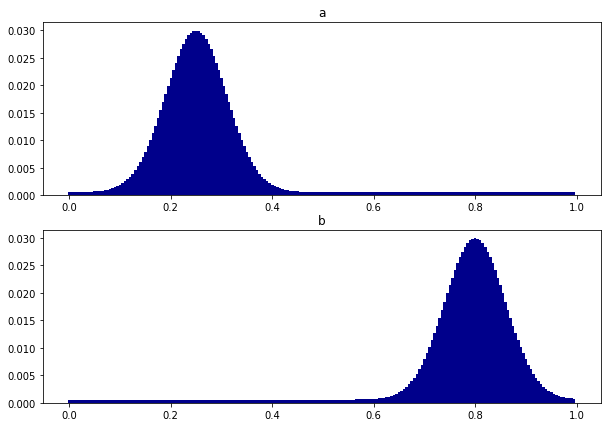

In [4]:
'''
Generate and plot two histograms.
'''
N = 200 # size of histogram
t = np.arange(0, N) / N # histogram bins

Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)

sigma = .06;
vmin = .02;
a = Gaussian(.25,sigma) # generate histograms
b = Gaussian(.8,sigma)

a = normalize( a+np.max(a)*vmin)
b = normalize( b+np.max(b)*vmin)

plt.figure(figsize = (10,7)) # plot

plt.subplot(2, 1, 1)
plt.bar(t, a, width = 1/len(t), color = "darkblue")
plt.title('a')
plt.subplot(2, 1, 2)
plt.bar(t, b, width = 1/len(t), color = "darkblue")
plt.title('b')

plt.show()

Next we'll compute the cost matrix $C$ and corresponding Gibbs kernel $K = e^{- C/\varepsilon}$. 


We'll use the squared distance as the cost of transport between bins $i$ and $j$

$$ C_{ij} = \left(\frac{i}{N} - \frac{j}{N} \right)^2,$$

so that the Gibbs kernel is a Gaussian convolution:

$$ K_{ij} = e^{-\frac{\left( i/N - j/N \right)^2}{ \varepsilon}}. $$

In [5]:
'''
Set regularization parameter epsilon. Compute cost matrix and Gibbs kernel.
'''
epsilon = 0.0009

[Y,X] = np.meshgrid(t,t)

C = (X-Y)**2
K = np.exp(-C/epsilon)

We run the algorithm for a fixed number of iterations.

In [6]:
u, v, errs = Sinkhorn(a, b, K, max_iter = 2000)

One way to track the progress of the algorithm as a function of iteration number is to quantify how closely the candidate solution at iteration $t$ satisfies the row and column sum constraints of the OT problem:

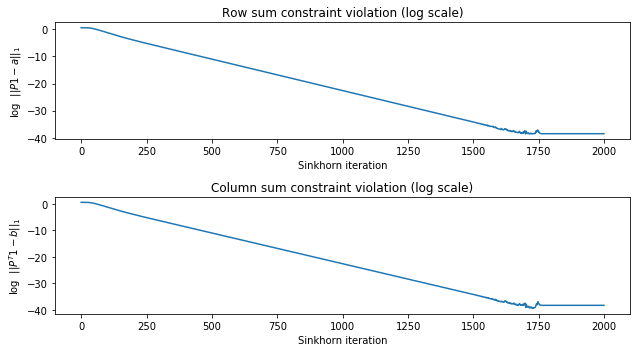

In [7]:
'''
Plot the constraint violations in log scale.
'''
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.plot([np.log(x[0]) for x in errs])
plt.title('Row sum constraint violation (log scale)')
plt.ylabel("$\log \ \ ||P 1 - a||_1$")
plt.xlabel('Sinkhorn iteration')


plt.subplot(2,1,2)
plt.plot([np.log(x[1]) for x in errs])
plt.title('Column sum constraint violation (log scale)')
plt.ylabel("$\log \ \ ||P^T 1 - b||_1$")
plt.xlabel('Sinkhorn iteration')

plt.tight_layout()
plt.show()

Finally, we can view the optimal transport plan $P_\varepsilon$ as a heatmap in which each tile shows the optimal allocation of mass from bin $i$ of histogram $a$ to bin $j$ of histogram $b$.

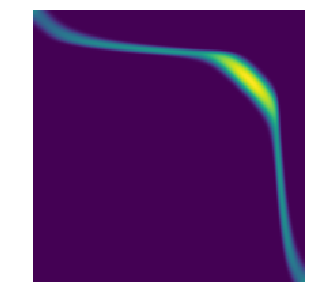

In [8]:
'''
Plot entropy-regularized OT solution.
'''
P = np.dot(np.dot(np.diag(u),K),np.diag(v)) # optimal transport plan
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.axis('off');

__Exercise__: How does our choice of the regularization parameter $\varepsilon$ affect the optimal transport plan $P_\varepsilon$? Experiment with different values for $\varepsilon$ and plot the resulting $P_\varepsilon$. Mathematically, what should we expect as $\varepsilon$ grows either very small or very large?

#### 1.3.2 Point clouds

We'll also consider an example of entropy-regularized optimal transport on _point clouds_. 



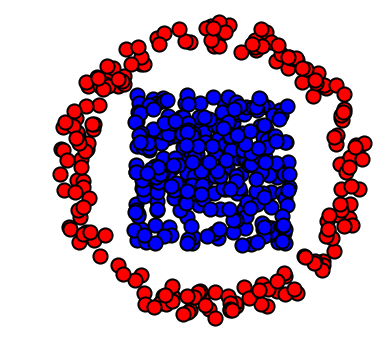

In [9]:
'''
Generate and plot two point clouds.
'''
# experiment parameters
N = [300, 200]
d = 2
epsilon = .01

# point cloud a: uniform draws from unit square
x = np.random.rand(2,N[0])-.5

# point cloud b: uniform draws from annulus surrounding square
theta = 2*np.pi*np.random.rand(1,N[1])
r = .8 + .2*np.random.rand(1,N[1])
y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))

# plot
def plotp(x, col):
    plt.scatter(x[0,:], x[1,:], s=200, edgecolors='k', c=col, linewidths=2)

plt.figure(figsize=(6,6))

plotp(x, 'blue')
plotp(y, 'red')

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

Again, we'll use the squared 2-norm (this time on a 2-D space) for the cost function:

$$ C(x,y) = \vert \vert x - y \vert \vert^2.$$


We'll set the target densities to be uniform weightings on the observed points. That is, to each observation $x_i$ we assign the weight $a_i = \frac{1}{N_x}$ and to each observation $y_j$ we assign the weight $b_j = \frac{1}{N_y}$, where $N_x$ and $N_y$ are the number of points in the point clouds $x$ and $y$, respectively.

In [10]:
'''
Define cost matrix, Gibbs kernel, and target histograms.
'''
# cost function
x2 = np.sum(x**2,0)
y2 = np.sum(y**2,0)
C = np.tile(y2,(N[0],1)) + np.tile(x2[:,np.newaxis],(1,N[1])) - 2*np.dot(np.transpose(x),y)

# Gibbs kernel
K = np.exp(-C / epsilon)

# target densities
a = np.ones(N[0])/N[0]
b = np.ones(N[1])/N[1]

We're now prepared to run Sinkhorn's algorithm.

In [11]:
'''
Compute optimal transport plan.
'''
u, v, errs = Sinkhorn(a, b, K, max_iter=2000)

As above, one way to track the progress of the algorithm is in terms of the marginal constraint violations of the candidate optimal transport plan $P_\varepsilon$.

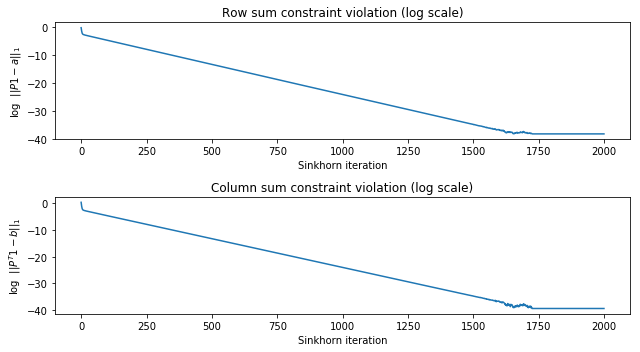

In [12]:
'''
Plot the constraint violations in log scale.
'''
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.plot([np.log(x[0]) for x in errs])
plt.title('Row sum constraint violation (log scale)')
plt.ylabel("$\log \ \ ||P 1 - a||_1$")
plt.xlabel('Sinkhorn iteration')


plt.subplot(2,1,2)
plt.plot([np.log(x[1]) for x in errs])
plt.title('Column sum constraint violation (log scale)')
plt.ylabel("$\log \ \ ||P^T 1 - b||_1$")
plt.xlabel('Sinkhorn iteration')

plt.tight_layout()
plt.show()

Finally, we'll consider some ways to visualize the results. Below we plot the largest individual components of the optimal transport plan as lines between elements of the two point clouds, with more solid lines indicating greater mass transport between the corresponding elements. 

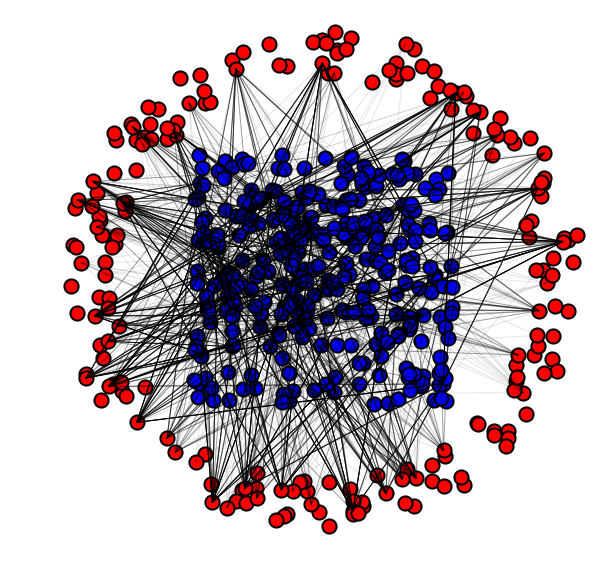

In [13]:
'''
Visualization: mass movements between point clouds.
'''
plt.figure(figsize=(10,10))

plotp(x, 'b')
plotp(y, 'r')

weights = np.arange(0.1,1,0.2)
for w in weights:

    A = P * (P > np.max(P)*w)
    i,j = np.where(A != 0) 
    plt.plot([x[0,i],y[0,j]], [x[1,i],y[1,j]], 'k', lw = 1, alpha=w)

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

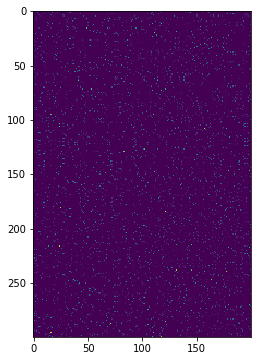

In [14]:
'''
Visualization: optimal transport plan as heat map.
'''
P = np.dot(np.dot(np.diag(u),K),np.diag(v)) # compute optimal transport plan

plt.figure(figsize=(4,6))
plt.imshow(P);

__Exercise__: There are quite a few parameters involved in the experiment presented in this section. If you have some extra time, try to build some intuition around this example by playing with these. For example, what happens when the point clouds have a highly unequal number of observations? What happens when the histogram weights aren't uniform? How does the strength of entropy regularization affect the optimal transport plan?

## Part II: Wasserstein barycenters

### 2.1 Intro

A key perspective on OT is that it is not only a method to compute minimial-cost transport plans between densities, but rather it provides a mathematically well-defined notion of __distance__ between densities whenever we can specify a unit cost of transport between two points in the space on which they are defined.

This perspective motivates the concept of a *Wasserstein barycenter*, which solves

$$ \min_{a \in \Sigma_n} \sum_{s=1}^S \lambda_s L_C(a, b_s),$$

where $\{b_s\}_{s=1}^S$ are a collection of histograms and $\lambda \in \Sigma_S$ are the weights assigned to each histogram when finding the barycenter $a$. A Wasserstein barycenter can thus be viewed as a weighted average between observed histograms, where the average is taken over the optimal transport costs between each observation and the barycenter.

### 2.2 Algorithm

As in the previous section, we approximate the solution to the Wasserstein barycenter problem above using an entropy-regularized version of the problem:

$$ \min_{a \in \Sigma_n} \sum_{s=1}^S \lambda_s L^\varepsilon_C(a, b_s).$$

A key advantage of this formulation is that it is equivalent to an optimization of a weighted sum of KL divergences over a set of $S$ couplings $P_s$ that share the barycenter $a$ as their row sum,

$$ a = P_1 1 = P_2 1 = \ \ ... \ \ = P_S 1,$$

and this problem in turn can be solved by an extension of the same Sinkhorn algorithm used in the previous section, where now have $S$ cost matrices $C_s$ and are required to find $S$ sets of scaling vectors $(u_s, v_s)$.

The algorithm proceeds as follows:

After first initializing

\begin{align*}
u_s = v_s = 1, \ \ s = 1, ..., S
\end{align*}

we iteratively update

\begin{align} 
v_s &\leftarrow \frac{b_s}{K_s^T u_s} \\
a &\leftarrow \prod_{s=1}^S (K_s v_s)^{\lambda_s} \\
u_s &\leftarrow \frac{a}{K_s v_s}. \end{align}


### 2.3 Example



#### 2.3.1 2-D histograms

We'll show an example using image data from MNIST. An image can be considered as a 2-D histogram, with bins corresponding to pixels, after normalizing pixel intensities.


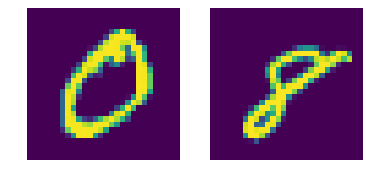

In [15]:
'''
Load, normalize, and plot two 2D histograms (i.e. images).
'''
# MNIST examples
zero_png = imageio.imread('../data/mnist_png/training/0/1.png')
eight_png = imageio.imread('../data/mnist_png/training/8/1013.png')

# scale and normalize
rescale = lambda x: (x - x.min()) / (x.max() - x.min())

zero_png = normalize(rescale(zero_png) + .01)
eight_png = normalize(rescale(eight_png) + .01)

# plot
plt.subplot(1,2,1)
plt.imshow(zero_png)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(eight_png)
plt.axis("off")

plt.show()

The algorithm is implemented in the code block below. It takes advantage of a fast convolutional implementation of kernel multiplication - see [this paper by Solomon et al.](https://hal.archives-ouvertes.fr/hal-01188953/document) for details. 

In [16]:
'''
Implement fast kernel multiplication and generalized Sinkhorn for entropic approximation of Wasserstein barycenters.
'''
epsilon = .04**2
N = zero_png.shape[0]
t = np.linspace(0,1,N)
[Y,X] = np.meshgrid(t,t)
K1 = np.exp(-(X-Y)**2/epsilon)

def K(x): # fast kernel implementation
    return np.dot(np.dot(K1,x),K1)

def barycenter_2d(A, K, lambd, n_iter = 4000, log_errs = True): 
    v = np.ones([N,N,R])
    u = np.copy(v)
    Err_q = np.zeros(n_iter)

    for i in range(n_iter):

        for k in range(R):
            if log_errs:
                Err_q[i] = Err_q[i] + np.linalg.norm(u[:,:,k]*K(v[:,:,k]) - A[:,:,k], 1)
            u[:,:,k] = A[:,:,k]/K(v[:,:,k])

        b = np.zeros(N)
        for k in range(R):
            b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
        b = np.exp(b)

        for k in range(R):
            v[:,:,k] = b/K(u[:,:,k])
            
    return Err_q, b

We'll first compute the Wasserstein barycenter using equal weights:

In [18]:
R = 2
A = np.stack((zero_png, eight_png), axis=2)
lambd = np.ones(R) / R
err, b = barycenter_2d(A, K, lambd)

As above, we can chart the progress of the algorithm by plotting the marginal constraint violation - in this case, we keep track of the sum of constraint violations for each of the input histograms.

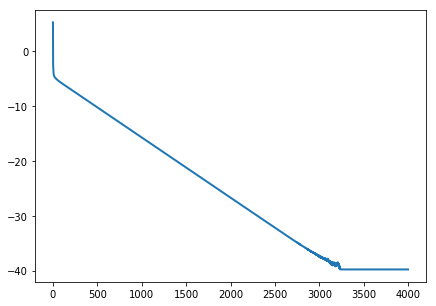

In [19]:
'''
Plot constraint violation vs. iteration number.
'''
plt.figure(figsize=(7,5))
plt.plot(np.log(err),linewidth = 2)
plt.show()

And of course we can view the barycenter, which is itself a histogram.

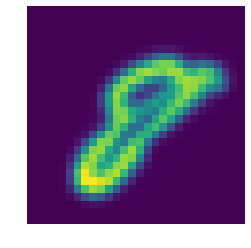

In [24]:
'''
Visualize barycenter.
'''
plt.imshow(b)
plt.axis("off");

For a more thorough view of how the Wasserstein barycenter interpolates between the two histograms, we can compute it for a sequence of weightings and view the resulting histograms:

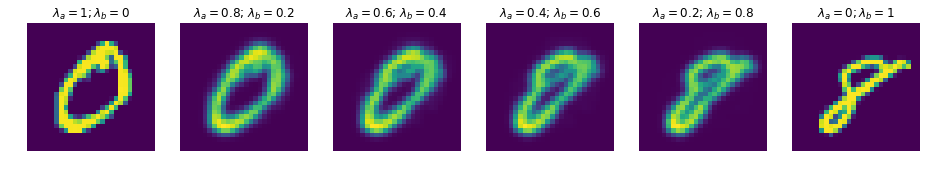

In [21]:
'''
Show sequence of barycenters corresponding to different weightings.
'''
plt.figure(figsize=(16,4))

plt.subplot(1,6,1)
plt.axis("off")
plt.imshow(zero_png)
plt.title("$\lambda_a = 1; \lambda_b = 0$")

ix = 1
for lam in np.arange(0.2,1.0,0.2):
    lambd = [1-lam, lam]
    _, b = barycenter_2d(A, K, lambd)
    
    plt.subplot(1,6,1+ix)
    plt.axis("off")
    plt.imshow(b)
    plt.title('$\lambda_a = $'+str(np.around(lambd[0], 1))+'; '+'$\lambda_b = $'+str(np.around(lambd[1], 1)))
    ix +=1
    
plt.subplot(1,6,6)
plt.axis("off")
plt.title("$\lambda_a = 0; \lambda_b = 1$")
plt.imshow(eight_png)

plt.show()

__Exercise:__ How do these results compare to what we would find if we simply took the pixel-wise arithmetic (weighted) mean between the two points?

## Part III: Optimal transport in computational neuroscience

### 3.1 Intro

Finally, some neuroscience!

The goal of this section is to show how the foregoing concepts can be adapted the to the solution of some modern problems in computational neuroscience. We will focus on the analysis of MEG data, which is represented as a collection of real, scalar, non-negative valued measurements at each vertex of a mesh uniformly covering the cortical surface. The measurements correspond to the amplitude of current dipoles with orientation normal to the cortical surface at each vertex location.

From the OT perspective, these measurements can be viewed as histograms, with each vertex corresponding to a unique histogram bin. The cost matrix will reflect the _geodesic distance_ between vertices, that is, the $(i,j)$ entry of the cost matrix represents the spatial distance between vertices $i$ and $j$, taking into account the curved shape of the cortical surface.

We'll start by loading some data and visualizing both an example signal and the cost matrix.

In [25]:
'''
Load some example data and use provided code to compute a cost matrix on the brain surface mesh.
'''
data_path = mne.datasets.sample.data_path()
subjects_dir = os.path.join(data_path, "subjects")

resolution = 4
spacing = 'ico%d' % resolution

# get surface mesh and compute distances between vertices
surf, dist = get_surf_dist(spacing, subjects_dir)
n_features = len(dist)

# summarize result
print('Pairwise vertex distance matrix has size: {}'.format(dist.shape))
print('Maximum distance between vertices: {:.2f} cm'.format(100 * dist.max()))

# generate surface map
bg_map = os.path.join(subjects_dir, "fsaverage/surf/lh.sulc")
bg_map = nilearn.surface.load_surf_data(bg_map)[:n_features]

Computing source space ...
Running Floyd-Warshall algorithm to compute distances...
Done!
Pairwise vertex distance matrix has size: (2562, 2562)
Maximum distance between vertices: 23.63 cm


In [26]:
'''
Get vertex labels and simulate a source signal.
'''
label_name = 'lh.BA45'
fname_label = os.path.join(subjects_dir,
                           'fsaverage/label/%s.label' % label_name)
label = mne.read_label(fname_label, subject="fsaverage")
label = label.morph(subject_to="fsaverage", grade=resolution,
                    subjects_dir=subjects_dir)


# simulate signal on subset of label vertices
seed = 42
rng = np.random.RandomState()

activation_size = 20
activations = np.zeros((n_features, 1))

picks = rng.choice(label.vertices, activation_size)
signal = rng.rand(activation_size)
activations[picks, 0] = signal / np.sum(signal) # signal is a valid histogram

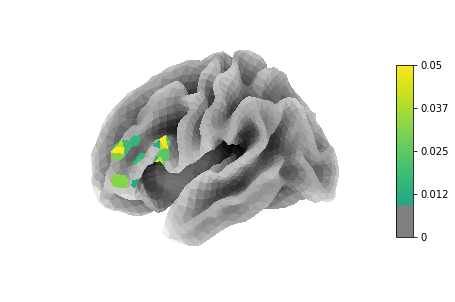

In [27]:
'''
View the simulted signal.
'''
view = plotting.plot_surf_stat_map(surf, activations, colorbar=True,
                                   alpha=1., threshold=0.01, cmap="viridis",
                                   bg_map=bg_map, vmax=activations.max() / 2)

We can also visualize the cost matrix by plotting distances from a fixed vertex.

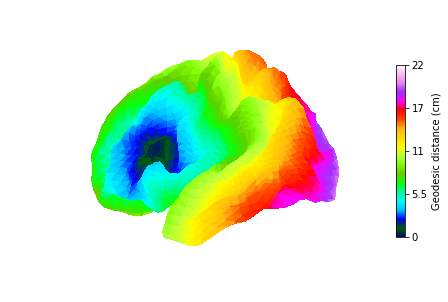

In [28]:
'''
Visualize cost as distance from a fixed point on the cortical surface.
'''
reference_vertex = 120 # reference vertex chosen to be roughly near simulated signal

view = plotting.plot_surf_roi(surf, 100 * dist[reference_vertex], colorbar=True)
ax, colorbar_ax = view.get_axes()
_ = colorbar_ax.set_ylabel("Geodesic distance (cm)")

### 3.2 Wasserstein barycenters of brains

One recent application for OT in computational neuroscience is motivated by the problem of pooling information about the spatial localization of signals across many recordings, as might be obtained, for example, in a group study involving several individuals. The challenge is to identify a principled method to summarize a collection of signals. In this section, we illustrate an OT approach that computes the Wasserstein barycenter of a collection of source signals on a human brain surface.


We'll start by simulating a collection of signals in source space, corresponding to the measurements that might be obtained from different subjects. 

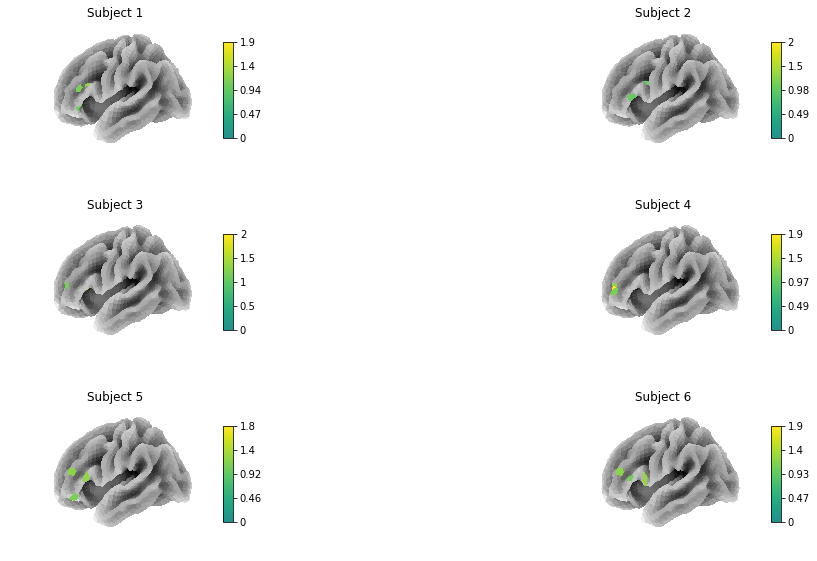

In [29]:
'''
Simulate and visualize a collection of signals in source space.
'''
# simulate activations
n_subjects = 6
activation_size = 3
activations = np.zeros((n_features, n_subjects))
for i in range(n_subjects):
    picks = rng.choice(label.vertices, activation_size)
    activations[picks, i] = rng.rand(activation_size) + 3
    
    
# plot
f, axes = plt.subplots(n_subjects // 2, 2, subplot_kw={'projection': '3d'}, figsize=(18, 10))
axes = axes.ravel()
for i in range(n_subjects):
    view = plotting.plot_surf_stat_map(surf, activations[:, i], colorbar=True,
                                       alpha=1., threshold=0.01, cmap="viridis",
                                       bg_map=bg_map, axes=axes[i],
                                       vmax=activations[:, i].max() / 2)
    
    axes[i].set_title("Subject %d" % (i + 1))

The simplest way to summarize information across these signals would be to compute the arithmetic mean. Below, we show that this approach results in a spatially diffuse summary. As the exercise below demonstrates, this shortcoming arises from an implicit, overly simplistic assumption about the distances between points on the cortical surface.

__Exercise:__ Show that the arithmetic mean corresponds to the Wasserstein barycenter of observations $b_s \in \mathbb{R}$, $s = 1,...,S$ when $L^\varepsilon_C(a, b_s) = ||a-b_s||_2^2$ and $\lambda_1 = ... = \lambda_S = 1/S$.

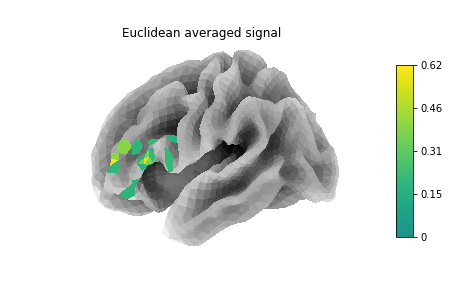

In [30]:
'''
Compute and plot the naive (Euclidean) average.
'''
euclidean_mean = abs(activations).mean(axis=1)
view = plotting.plot_surf_stat_map(surf, euclidean_mean, colorbar=True, cmap="viridis",
                                   alpha=1., threshold=0.01,
                                   bg_map=bg_map, vmax=euclidean_mean.max() / 2,
                                  title='Euclidean averaged signal')


Instead, we compute the Wasserstein barycenter of the simulated signals, using the distance matrix computed above as the ground cost of transport between points on the cortical surface.

*Technical note*: Strictly speaking, the Wasserstein barycenter is only defined on histograms, and (as would also be the case with real MEG source signals) the data simulated above are not histograms because they are not normalized. Fortunately, the same approach generalizes to this unnormalized case, via a formulation known as "unbalanced optimal transport" - this is what is implemented below (see references for more details). 

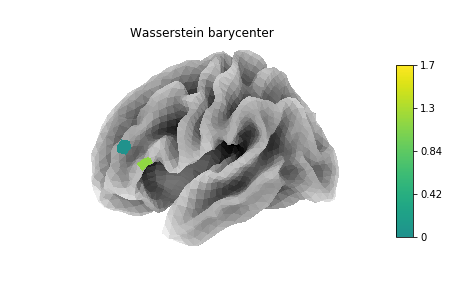

In [32]:
'''
Compute and plot the Wasserstein barycenter.
'''
M = dist / np.median(dist)  # this normalization by the median works well in practice
epsilon = 1. / n_features 
alpha = 10.  # regularization for unbalanced OT
barycenter = barycenter_unbalanced(abs(activations) + 1e-10, M, epsilon, alpha) # compute barycenter


view = plotting.plot_surf_stat_map(surf, barycenter, colorbar=True, cmap="viridis",
                                   alpha=1., threshold=0.01,
                                   bg_map=bg_map, vmax=barycenter.max() / 2,
                                  title='Wasserstein barycenter')

In contrast with the Euclidean average, the Wasserstein barycenter is spatially well-resolved and properly accounts for the distances between points on the curved and folded cortical surface.

### 3.3 Optimal transport regularization for MEG source imaging

#### 3.3.1 Intro

Finally, we discuss the application of these OT tools to a problem of scientific interest: group-level source imaging with MEG data. Source imaging is an inverse problem in which a lower-dimensional observed signal is mapped to a high-dimensional but unobserved source space. The source signal is related to the observed signal by a linear mapping derived from physical laws. The inverse problem, however, is ill-posed, and thus requires some form of regularization.

In a group study, signals are recorded from multiple individuals under the same experimental condition, and the objective is to infer a source signal for each individual. This is known as the "multi-task" setting in machine learning.

Together, these considerations give rise to the following problem:

$$ \min_{x_1, ..., x_S \in \mathbb{R}^p} \frac{1}{2n} \sum_{s=1}^S || y_S - L_s x_s ||_2^2 + \Omega(x_1, ..., x_S)$$

where $y_s \in \mathbb{R}^n$ is the observed signal, $L_s \in \mathbb{R}^{n \times p}$ is the known linear transformation from source to sensor space, $\Omega$ is a regularization term, and $s \in \{1, ..., S\}$ indexes the individuals in the group study.

#### 3.3.2 Regularization via the Wasserstein barycenter

Recently, OT has been applied to the group-level source imaging problem as a means to define the regularization term $\Omega$. By defining

$$ \Omega(x_1, ..., x_S) = \alpha \min_{b \in \mathbb{R}^p} \frac{1}{S} \sum_{s=1}^S L^\varepsilon_C(b, x_s),$$

the estimated signals $x_1, ..., x_S$ are encouraged to be "close" to each other in the sense of minimizing distance to the (equal-weight) Wasserstein barycenter. This reflects the expectation that there will be some similarity across individuals in the study.

The full problem is given by

$$ \min_{x_1, ..., x_S \in \mathbb{R}^p} \overbrace{\frac{1}{2n} \sum_{s=1}^S || y_S - L_s x_s ||_2^2}^{\text{fit to observed signal}} + \overbrace{\alpha \min_{b \in \mathbb{R}^p} \frac{1}{S} \sum_{s=1}^S L^\varepsilon_C(b, x_s)}^{\text{distance to signal barycenter}} + \underbrace{\beta ||x_s||_1}_{\text{sparsity}},$$

where the additional $||x_s||_1$ term enforces sparsity in the estimated signal. The parameters of the model are thus $\varepsilon$ (entropy smoothing), $\alpha$ (strength of Wasserstein penalty), and $\beta$ (strength of sparsity penalty). 


#### 3.3.3 Example

We include a small example using MEG recordings from two individuals. The data are obtained from [[3]](http://doi.org/10.5281/zenodo.889235); they have already been preprocessed, so that for each individual we have the corresponding gain matrix and sensor measurements.

In [39]:
'''
Load preprocessed MEG data, consisting of observed measurements and gain matrices for each individual.
'''
data_file = '../data/MEG_preprocessed.pkl'

with open(data_file, 'rb') as f:
    data = pickle.load(f)
    
gains = data['gain']
Ms = data['M']

print("Gain matrices : {} x {} x {} (n_subject x n_sensor x n_source)".format(*gains.shape))
print("Observed signal : {} x {} x {} (n_subject x n_sensor x time)".format(*Ms.shape))

Gain matrices : 2 x 204 x 5124 (n_subject x n_sensor x n_source)
Observed signal : 2 x 204 x 31 (n_subject x n_sensor x time)


Now we define an MTW model, which requires choosing the parameters $\varepsilon$, $\alpha$, $\beta$ defined above. The model is fit to the preprocessed data.

In [41]:
'''
Instantiate and fit a MTW model.
'''
M = Ms[:,:,20] # infer signal at time point 20

epsilon = 1. / n_features
alpha = 0.1
beta = 0.1
sigma0 = 0.01
mtw = MTW(M=dist, epsilon=epsilon, alpha=alpha, beta=beta, sigma0=sigma0) # instantiate MTW object

mtw = mtw.fit(gains[:,:,2562:], M) # fit to MEG data

Time ot 3.5 | Time cd 0.0


The results are stored in the MTW attribute coefs_: they have shape $(\text{n_source} \times \text{n_subject})$, corresponding to an estimated source signal for each subject. These are plotted below.

In [54]:
coefs = mtw.coefs_
coefs.shape 

(2562, 2)

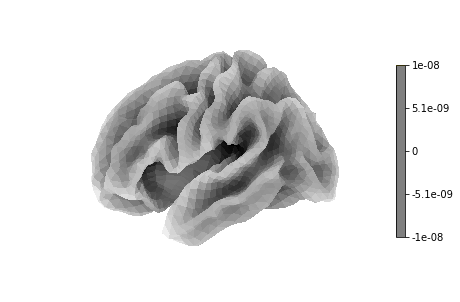

In [48]:
'''
Visualize the result.
'''

view = plotting.plot_surf_stat_map(surf, coefs[:,0], colorbar=True,
                                   alpha=1., threshold=0.01, cmap="viridis",
                                   bg_map=bg_map, vmax=coefs[:,0].max() / 2)

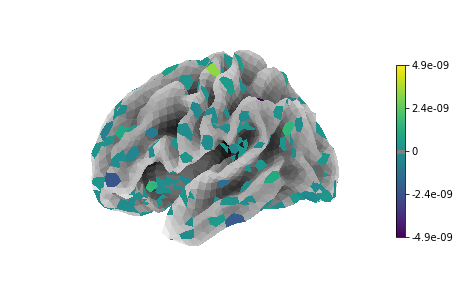

In [47]:
view = plotting.plot_surf_stat_map(surf, coefs[:,1], colorbar=True,
                                   alpha=1., threshold=1e-10, cmap="viridis",
                                   bg_map=bg_map, vmax=coefs[:,1].max() / 2)

## Acknowlegments

A. Greaves-Tunnell and Z. Harchaoui would like to warmly thank H. Janati, A. Gramfort, N. Courty, M. Cuturi, G. Peyré, R. Flamary, for generously sharing their codes and notebooks. The neuroscience component of the lab is largely based on the companion codes to the papers [1] and [2], while exposition of OT concepts is based on G. Peyré's excellent [Numerical Tours](https://www.numerical-tours.com/python/), particularly the [notebook on entropic regularization](https://nbviewer.jupyter.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_5_entropic.ipynb).

## References and further resources

[1] Janati, H., Bazeille, T., Thirion, B., Cuturi, M., & Gramfort, A. [Group level MEG/EEG source imaging via optimal transport: minimum Wasserstein estimates.](https://arxiv.org/pdf/1902.04812.pdf) _In International Conference on Information Processing in Medical Imaging_. (2019)

[2] Janati, H., Cuturi, M., & Gramfort, A. [Wasserstein regularization for sparse multi-task regression.](https://arxiv.org/pdf/1805.07833.pdf) arXiv preprint arXiv:1805.07833. (2018)

[3] Nurminen J., Paananen H., Mäkelä J. [High frequency somatosensory MEG: evoked responses, FreeSurfer reconstruction](http://doi.org/10.5281/zenodo.889235). (2017)

[4] Solomon, J., De Goes, F., Peyré, G., Cuturi, M., Butscher, A., Nguyen, A., Du, T. and Guibas, L. [Convolutional wasserstein distances: Efficient optimal transportation on geometric domains.](https://hal.archives-ouvertes.fr/hal-01188953/document) _ACM Transactions on Graphics (TOG), 34(4), p.66._ (2015)


The section on Wasserstein barycenters for brains is based on the example notebook in H. Janati's GitHub repository [GitHub repository](https://github.com/hichamjanati/OT-tutorials).

For an extensive introduction to the theory, computational aspects, and applications of optimal transport, we refer interested readers to the textbook of Cuturi and Peyré:

- Peyré, G., & Cuturi, M. (2019). [Computational Optimal Transport.](https://arxiv.org/pdf/1803.00567.pdf) Foundations and Trends in Machine Learning, 11(5-6), 355-607.